## Modeling Critical Food Violation by Food Establishments in the City of Chicago

## Project Plan
 - Project Goal
 - Dataset and features
 - Exploratory data analysis (EDA) 
 - Patterns, insights, pecularities of data
 - Data preprocessing
 - Feature engineering and description
 - Cross-validation, hyperparameter tuning
 - Validation and learning curves
 - Prediction for hold-out and test samples
 - Model evaluation with metrics description
 - Conclusions


### Project Goal
The goal of this project is to model the vilolations by the food establishments in the city of chicago. 

### Data Set and Features  
We used city of Chicago's Socrata Open Data (SODA) API to acess food inspection data for first 3 months of 2019. In addition to the food inspection data, we are using burglary/crime, 311 sanitation complaints, businesss license data as well.

## Exploratory Data Analysis 

In [1]:
#important libraries
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
sns.set(rc={'figure.figsize':(12, 6),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="darkgrid")
import matplotlib.dates as mdates
import re
from datetime import datetime, timedelta
import time
from datetime import datetime, date, time, timedelta


In [2]:
food_data = pd.read_json('../data/raw/food-inspection.json', convert_dates = ['inspection_date'])

In [3]:
food_data.head(2)

,address,aka_name,city,dba_name,facility_type,inspection_date,inspection_id,inspection_type,latitude,license_,location,longitude,results,risk,state,violations,zip
0,1958 W CHICAGO AVE,SUBWAY,CHICAGO,SUBWAY,Restaurant,2019-01-22,2252942,Canvass,41.896023,1677083,"{'type': 'Point', 'coordinates': [-87.67699521...",-87.676995,Pass w/ Conditions,Risk 1 (High),IL,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",60622.0
1,4503-4505 N KEDZIE AVE,EL ORIGINAL GALLO BRAVO,CHICAGO,EL ORIGINAL GALLO BRAVO,Restaurant,2019-01-11,2252352,Canvass,41.963157,2368636,"{'type': 'Point', 'coordinates': [-87.70815959...",-87.708160,Out of Business,Risk 1 (High),IL,None,60625.0


In [4]:
shape = food_data.shape
print(" So there are %d rows and %d columns in the data" % (shape[0], shape[1]))

 So there are 4315 rows and 17 columns in the data


In [5]:
#what's in the data? 
food_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4315 entries, 0 to 999
Data columns (total 17 columns):
address            4315 non-null object
aka_name           4289 non-null object
city               4310 non-null object
dba_name           4315 non-null object
facility_type      4276 non-null object
inspection_date    4315 non-null datetime64[ns]
inspection_id      4315 non-null int64
inspection_type    4315 non-null object
latitude           4295 non-null float64
license_           4315 non-null int64
location           4295 non-null object
longitude          4295 non-null float64
results            4315 non-null object
risk               4311 non-null object
state              4314 non-null object
violations         3344 non-null object
zip                4311 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(2), object(11)
memory usage: 606.8+ KB


In [6]:
#simple statistics 
food_data.describe()

,inspection_id,latitude,license_,longitude,zip
count,4.315000e+03,4295.000000,4.315000e+03,4295.000000,4311.000000
mean,2.264776e+06,41.885686,1.861125e+06,-87.682541,60630.407098
std,1.366153e+04,0.083692,9.684546e+05,0.057104,27.049660
min,2.015566e+06,41.653637,0.000000e+00,-87.914428,60018.000000
25%,2.253036e+06,41.848736,1.531966e+06,-87.713291,60615.000000
50%,2.262125e+06,41.895615,2.271575e+06,-87.674668,60629.000000
75%,2.279264e+06,41.945976,2.560618e+06,-87.641278,60646.000000
max,2.282717e+06,42.021064,3.808890e+06,-87.527970,60827.000000


In [7]:
def count_critical_violations(violations):
    non_critical_violations_count = 0
    critical_violations_count = 0
    minor_violations_count = 0
    try:
        x = violations.split('|')
        codes = []
        for violation in x:
            match = int(re.search(r'\d+', violation).group(0))
            codes.append(match)
        for code in codes:
            if code > 0 and code < 15:
                minor_violations_count += 1
            elif code > 15 and code < 30:
                non_critical_violations_count += 1
            else:
                critical_violations_count += 1
        return [minor_violations_count, non_critical_violations_count, critical_violations_count]
        #return(critical_violations_count)
    except:
        return [0]    

In [8]:
food_data['violations_list'] = food_data['violations'].apply(lambda x: count_critical_violations(x))
food_data['minor_violations'] = food_data['violations_list'].apply(lambda x : x[0])
food_data['non_critical_violations'] = food_data['violations_list'].apply(lambda x : x[1] if len(x) > 1 else 0)
food_data['critical_violations'] = food_data['violations_list'].apply(lambda x : x[2] if len(x) > 1 else 0)

In [9]:
food_data.head(2)

,address,aka_name,city,dba_name,facility_type,inspection_date,inspection_id,inspection_type,latitude,license_,location,longitude,results,risk,state,violations,zip,violations_list,minor_violations,non_critical_violations,critical_violations
0,1958 W CHICAGO AVE,SUBWAY,CHICAGO,SUBWAY,Restaurant,2019-01-22,2252942,Canvass,41.896023,1677083,"{'type': 'Point', 'coordinates': [-87.67699521...",-87.676995,Pass w/ Conditions,Risk 1 (High),IL,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",60622.0,"[1, 1, 4]",1,1,4
1,4503-4505 N KEDZIE AVE,EL ORIGINAL GALLO BRAVO,CHICAGO,EL ORIGINAL GALLO BRAVO,Restaurant,2019-01-11,2252352,Canvass,41.963157,2368636,"{'type': 'Point', 'coordinates': [-87.70815959...",-87.708160,Out of Business,Risk 1 (High),IL,None,60625.0,[0],0,0,0


#### Let's drop some redudant and unnecessary columns from the dataframe and also clean up column_names.

In [10]:
food_data = food_data.drop(['violations_list', 'location', 'violations', 'zip', 'state'], axis=1)
food_data.rename(columns={'license_':'license'}, inplace=True)

In [11]:
food_data.head(2)

,address,aka_name,city,dba_name,facility_type,inspection_date,inspection_id,inspection_type,latitude,license,longitude,results,risk,minor_violations,non_critical_violations,critical_violations
0,1958 W CHICAGO AVE,SUBWAY,CHICAGO,SUBWAY,Restaurant,2019-01-22,2252942,Canvass,41.896023,1677083,-87.676995,Pass w/ Conditions,Risk 1 (High),1,1,4
1,4503-4505 N KEDZIE AVE,EL ORIGINAL GALLO BRAVO,CHICAGO,EL ORIGINAL GALLO BRAVO,Restaurant,2019-01-11,2252352,Canvass,41.963157,2368636,-87.708160,Out of Business,Risk 1 (High),0,0,0


#### Let's see the frequency of these inspections. 

Text(0.5, 0, 'Inspection Date')

Text(0, 0.5, 'Number of Inspections')

Text(0.5, 1.0, 'Daily Inspections')

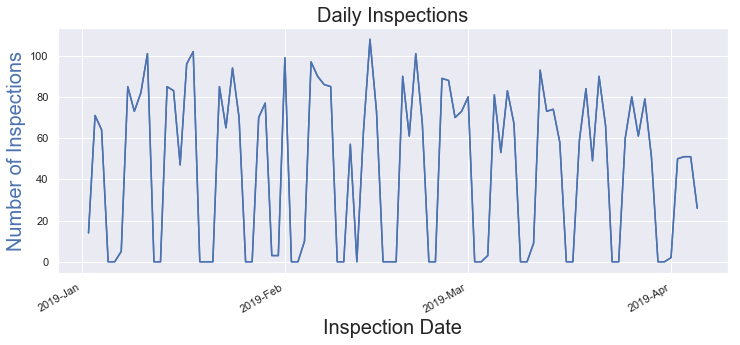

In [12]:
per_day = pd.DataFrame()
per_day =  food_data[['inspection_date', 'inspection_id']]
per_day = per_day.set_index(pd.to_datetime(per_day['inspection_date']))
per_day = per_day.resample('D').count()
plt.rcParams['figure.figsize'] = 12,5
fig, ax = plt.subplots()
fig.autofmt_xdate()
#
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.DayLocator())
monthFmt = mdates.DateFormatter('%Y-%b')
ax.xaxis.set_major_formatter(monthFmt)

plt.plot(per_day.index, per_day, 'b-')
plt.xlabel('Inspection Date')
plt.ylabel('Number of Inspections', color='b')
plt.title('Daily Inspections')
plt.show()

In [13]:
print("%s unique facilites were inspected during the period" %food_data['license'].nunique())

3259 unique facilites were inspected during the period


### Let's look at the results of these inspection more closely: 
A facility can either pass, pass with conditions or fail. Following is an excerpt from the dataset documentation page:

"Establishments receiving a ‘pass’ were found to have no critical or serious violations (violation number 1-14 and 15-29, respectively). Establishments receiving a ‘pass with conditions’ were found to have critical or serious violations, but these were corrected during the inspection. Establishments receiving a ‘fail’ were found to have critical or serious violations that were not correctable during the inspection. An establishment receiving a ‘fail’ does not necessarily mean the establishment’s licensed is suspended. Establishments found to be out of business or not located are indicated as such".

In [14]:
food_data['results'].value_counts()

Pass w/ Conditions    1957
Pass                   951
Fail                   806
Out of Business        261
No Entry               216
Not Ready              124
Name: results, dtype: int64

Text(0.5, 1.0, 'Result of Inspections')

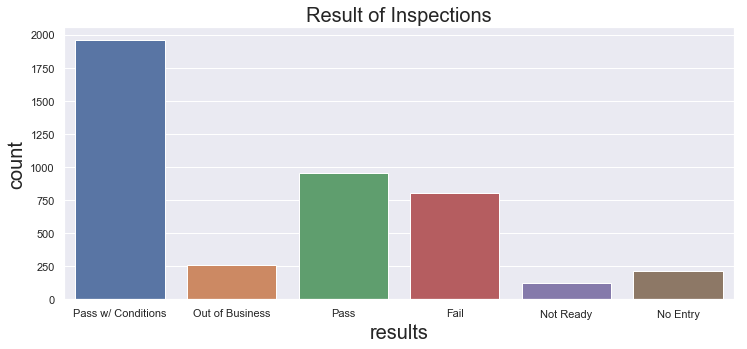

In [16]:
ax = sns.countplot(x="results", data=food_data)
plt.title("Result of Inspections")
plt.show()

### Let's convert results in to categorical variable first and the we will filter out non-relevant categories like 'Out of Business', 'Not Ready' and 'No Entry' facilities. 

In [17]:
results_conv = {"results" : {"Fail" : 0, "Pass" : 1, "Pass w/ Conditions" : 1, "Out of Business": 2, "No Entry": 3 , "Not Ready": 4}}
food_data.replace(results_conv, inplace=True)
print(food_data.results.dtype)

int64


In [18]:
food_data = food_data[food_data['results'] < 2]

Text(0.5, 1.0, 'Result of Inspections')

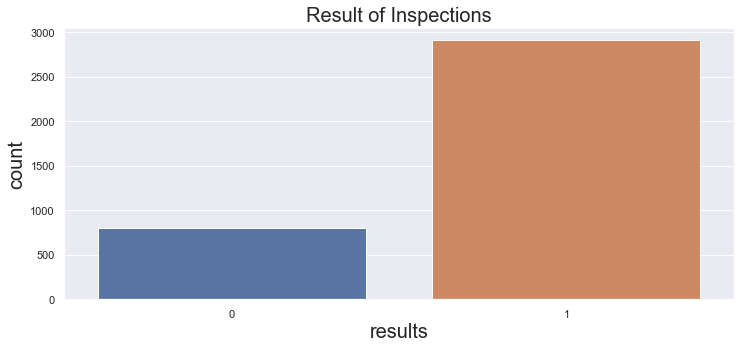

In [19]:
ax = sns.countplot(x="results", data=food_data)
plt.title("Result of Inspections")
plt.show()

Text(0.5, 1.0, 'Distribution of Critical Violations')

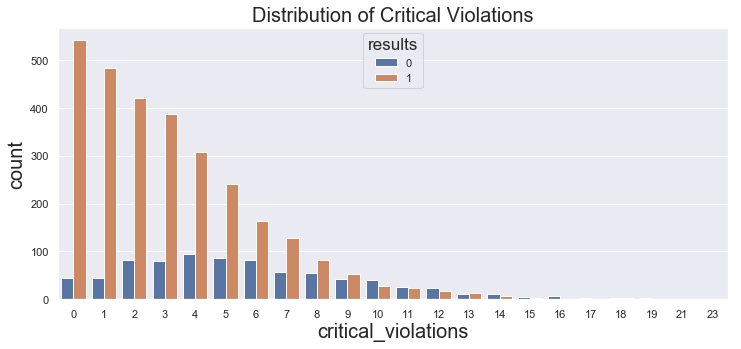

In [20]:
ax = sns.countplot(x="critical_violations", hue = 'results', data=food_data)
plt.title("Distribution of Critical Violations")
plt.show()

This clearly shows more the number of critical violations, more the failure rate.  

###  Inspection type: 
According to the dataset description, an inspection can be of the following types:

1) Canvass : The most common type of inspection performed at a frequency relative to the risk of the establishment

2) Consultation: when the inspection is done at the request of the owner prior to the opening of the establishment

3) Complaint: when the inspection is done in response to a complaint against the establishment

4) license : when the inspection is done as a requirement for the establishment to receive its license to operate

5) suspect food poisoning : when the inspection is done in response to one or more persons claiming to have gotten ill as a result of eating at the establishment (a specific type of complaint based inspection)

6) Task-force inspection: when an inspection of a bar or tavern is done.

7) Re-inspections:  Occurs for most types of these inspections and are indicated as such.pe



In [21]:
food_data['inspection_type'].value_counts()

Canvass                                   1953
License                                    530
Canvass Re-Inspection                      474
Complaint                                  346
License Re-Inspection                      188
Complaint Re-Inspection                    153
Short Form Complaint                        29
Suspected Food Poisoning                    23
Recent Inspection                           11
Suspected Food Poisoning Re-inspection       6
Consultation                                 1
Name: inspection_type, dtype: int64

#### A picture speaks thousands numbers, right ? Let's look at these numbers as count plots. 

<Figure size 864x432 with 0 Axes>

Text(0.5, 1.0, 'Result of Inspections')

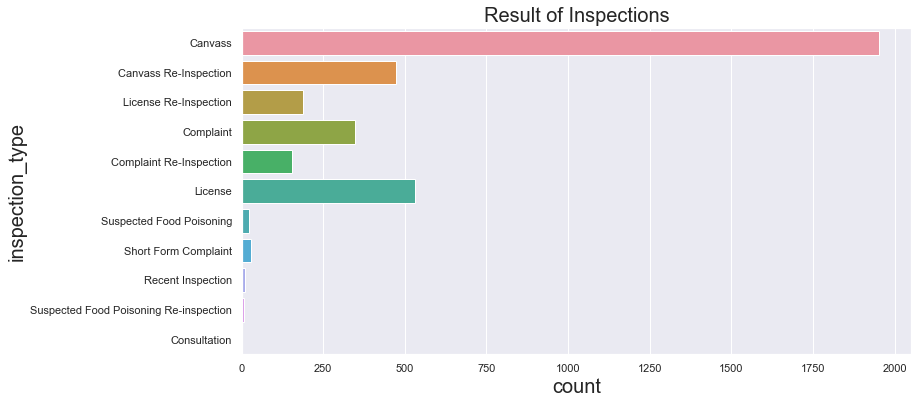

In [22]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(y="inspection_type", data=food_data)
plt.title("Result of Inspections")
plt.show()

#### Since our goal is here to model the failure in random canvas, we are going to focus on canvass inspections only. 

In [23]:
food_data = food_data[food_data['inspection_type'] == 'Canvass']

In [24]:
#food_data = food_data[(food_data['results']== 1) | (food_data['results']== 2) ]

In [25]:
print("%d different types of food establishment facilities were inspected during the period and %d different types of inpsections were conducted during the period."% 
(food_data['facility_type'].nunique(), food_data['inspection_type'].nunique()))

33 different types of food establishment facilities were inspected during the period and 1 different types of inpsections were conducted during the period.


In [26]:
plt.figure(figsize=(13, 13))
food_data['facility_type'].value_counts()[0:10]

<Figure size 936x936 with 0 Axes>

Restaurant                         1297
School                              454
Grocery Store                        94
Long Term Care                       21
Children's Services Facility         18
Bakery                               15
Catering                              9
Daycare Above and Under 2 Years       6
Golden Diner                          6
Daycare (2 - 6 Years)                 5
Name: facility_type, dtype: int64

<Figure size 936x936 with 0 Axes>

Text(0.5, 1.0, 'Types of Facilities Inspected')

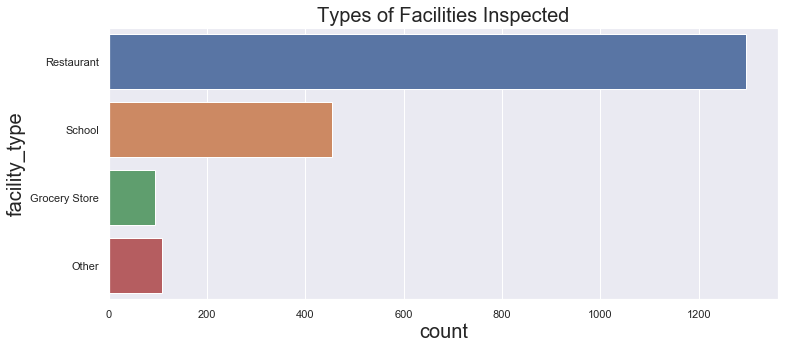

In [29]:
# Setting anything other than Restaurants, Grocery store and School to other types
ftype = lambda x: "Other" if x not in ['Restaurant', 'Grocery Store', 'School'] else x
food_data['facility_type'] = food_data['facility_type'].map(ftype)
ax = sns.countplot(y="facility_type", data=food_data)
plt.title("Types of Facilities Inspected")
plt.show()

### Risk categories: 
    
Each establishment is categorized as to its risk of adversely affecting the public’s health:

 1: High

 2: Medium 

 3: Low 

The frequency of inspection is tied to this risk, with risk 1 establishments inspected most frequently and risk 3 least frequently.

<Figure size 864x576 with 0 Axes>

Risk 1 (High)      1817
Risk 2 (Medium)     121
Risk 3 (Low)         15
Name: risk, dtype: int64

Text(0.5, 1.0, 'Risk')

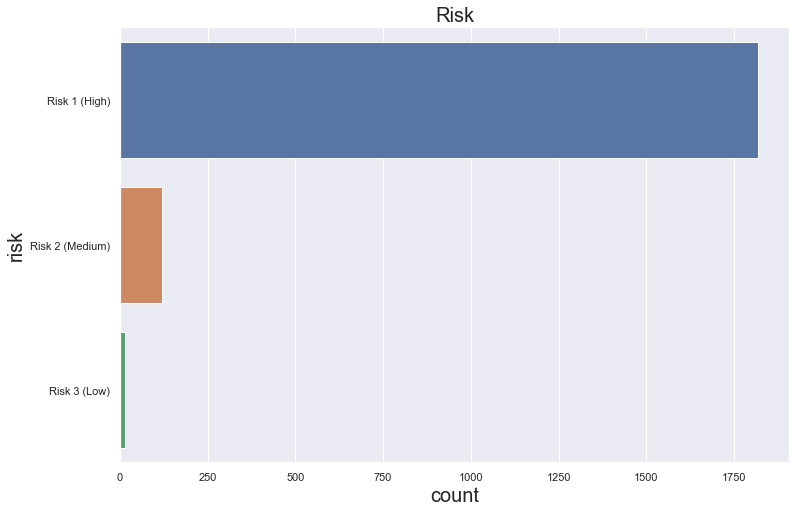

In [30]:
plt.figure(figsize=(12, 8))
food_data['risk'].value_counts()[0:10]
ax = sns.countplot(y="risk", data=food_data)
plt.title("Risk")
plt.show()

## Label Encoding categorical variables:

There are couple different ways of label encoding categorical variables.

1) First method is to replace those variables with a dictionary involving key and value pairs of the variables to be encoded. 

2) Another method is to change their type as categorical variable. Let's convert inspection_type for example as as categorical variable. 

In [31]:
#food_data["inspection_type"] = food_data["inspection_type"].astype('category')
food_data["facility_type"] = food_data["facility_type"].astype('category')
food_data["risk"] = food_data["risk"].astype('category')
#food_data["inspection_type_cat"] = food_data["inspection_type"].cat.codes
food_data["facility_type_cat"] = food_data["facility_type"].cat.codes
food_data["risk_type_cat"] = food_data["risk"].cat.codes

#### I want to see look these establishments in the map. For plotting, let's divide them into pass and fail data frames.

In [33]:
pass_inspection = food_data[(food_data['results']== 1)]
fail_inspection = food_data[food_data['results']== 0]

### Let's utilize plotly and mapbox to display these restaurants in a map:

In [34]:
import plotly.plotly as py
import plotly.graph_objs as go
mapbox_access_token = "pk.eyJ1IjoiZGlwYWtyaW1hbCIsImEiOiJjanR0NHp5Z3gxOGVtNGVsbHIxOGI3ZmV6In0.bmrI81LR7L441sUKqDeKmw"

data_pass = [
    go.Scattermapbox(
        lat=pass_inspection['latitude'],
        lon=pass_inspection['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12,
            color='rgb(50, 200, 55)',
            opacity=0.7
        ),
        text = pass_inspection['dba_name']  + ' <br> Pass ',
        hoverinfo='text'
    ),
    go.Scattermapbox(
        lat=fail_inspection['latitude'],
        lon=fail_inspection['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12, 
            color='rgb(255, 0, 0)',
            opacity=0.7
        ),
         text = fail_inspection['dba_name'] + ' <br> Fail ',
         hoverinfo='text'
    )   
]

layout = go.Layout(
    title = "Chicago Food Insepections",
    width=600,
    height=800,
    showlegend=False,
    hovermode='closest',
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=41.9,
            lon=-87.7
        ),
        pitch=10,
        zoom=9,
        style='outdoors'
    ),
)

fig = go.Figure(data=data_pass, layout=layout)

py.iplot(fig, filename='Chicago')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~dipakrimal/0 or inside your plot.ly account where it is named 'Chicago'


/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [35]:
food_data.head(5)

,address,aka_name,city,dba_name,facility_type,inspection_date,inspection_id,inspection_type,latitude,license,longitude,results,risk,minor_violations,non_critical_violations,critical_violations,facility_type_cat,risk_type_cat
0,1958 W CHICAGO AVE,SUBWAY,CHICAGO,SUBWAY,Restaurant,2019-01-22,2252942,Canvass,41.896023,1677083,-87.676995,1,Risk 1 (High),1,1,4,2,0
1003,606 S STATE ST,Jones Academy High School,CHICAGO,Jones Academy High School,School,2019-01-10,2252303,Canvass,41.874419,2132,-87.627755,1,Risk 1 (High),2,0,1,3,0
1004,4646 N MARINE DR,LOUIS A. WEISS MEMORIAL HOSPITAL,CHICAGO,LOUIS A. WEISS MEMORIAL HOSPITAL,Restaurant,2019-02-21,2268322,Canvass,41.966860,1249761,-87.649135,0,Risk 1 (High),0,1,9,2,0
1005,3141 W JACKSON BLVD,ALAIN LOCKE CHARTER ACADEMY,CHICAGO,ALAIN LOCKE CHARTER ACADEMY,School,2019-02-21,2268270,Canvass,41.877221,2206680,-87.705241,1,Risk 1 (High),0,0,2,3,0
1006,1852 W NORTH AVE,THE PASTA BOWL,CHICAGO,THE PASTA BOWL,Restaurant,2019-02-11,2261851,Canvass,41.910639,2374782,-87.674707,1,Risk 1 (High),3,0,8,2,0


#### I also want to use Yelp's rating and comments ( for some sort of sentiment analysis if possible) in my model. So let's see if that is feasible. To start with, I am focusing only on the restaurants (category) that failed in the inspection. Also note taht yelp caps 5000 API calls per per day so I chose to focus on failed restaurants only. 

In [38]:
res_fail = fail_inspection[fail_inspection['facility_type_cat'] == 2]

### Let's write some functions to use Yelp API. 

In [39]:
# yelp authorization ( Need to hide this ! )
import requests
api_key='skulWTrlVslLqkj5vY7u9fJErIOi-FB1prbAhB4ftwLLBSN5CarHecqiOPET6gVDOUhiEfvMD5O8tn--Evkbdn0MujX5Lncp5TNPNw_rzT_pAHtW0qIBC0pPgcqrXHYx' 
headers = {'Authorization': 'Bearer %s' % api_key,}

In [40]:
# find business match using business name (aka_name dba(doing business as name) 
def get_business_match(name, address, city="Chicago", state='IL', country='US'):
    params = {}
    params["name"] = name 
    params["address1"] = address
    params["city"] = 'Chicago'
    params["state"] = 'IL'
    params["country"] = 'US'
    
    request = requests.get("https://api.yelp.com/v3/businesses/matches",headers=headers,params=params)
    #Transforms the JSON API response into a Python dictionary
    data = request.json()
    try:
        return data['businesses'][0]['id']
    except:
        return 0

In [41]:
## pull ratings and reviews of the matched businesses.

def get_reviews(business_id):
    query = "https://api.yelp.com/v3/businesses/%s/reviews" %business_id
    try:
        request = requests.get(query, headers=headers)
        data = request.json()
        return data
    except:
        ValueError("This business doesn't have any reviews")
        
def get_rating(business_id):
    try:
        query = "https://api.yelp.com/v3/businesses/%s" %business_id
        request = requests.get(query, headers=headers)
        data = request.json()
        return data["rating"]
    except:
        return 9999

In [42]:
def get_business_rating(name, address, city="Chicago", state='IL', country='US'):
    params = {}
    params["name"] = name 
    params["address1"] = address
    params["city"] = 'Chicago'
    params["state"] = 'IL'
    params["country"] = 'US'
    
    request = requests.get("https://api.yelp.com/v3/businesses/matches",headers=headers,params=params)
    #Transforms the JSON API response into a Python dictionary
    data = request.json()
    try:
        return get_rating(['businesses'][0]['id'])
        
    except:
        return 9999

### Let's pull the information from the failed restaurants. 

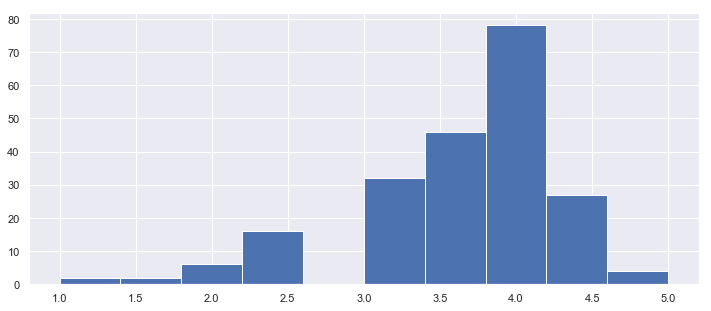

In [43]:
res_fail['yelp_id'] = res_fail.apply(lambda x: get_business_match(x['aka_name'], x['address']), axis=1)
res_fail['rating'] = res_fail.apply(lambda x: get_rating(x["yelp_id"]), axis=1)
res_fail[res_fail['rating'] < 6]['rating'].hist()

That is encouraging! Looks like we can factor in those yelp ratings in our model. The mean rating has a peak at 4 even for failed restaurants but there is also a significant tail at the lower end of the spectrum. I may end of using it but I will have to set up a cronjob to make daily api calls for all these businesses.

## Burglary Data
Is there any connection with the crime and food inspection failures? May be ! For now, I am focusing on the burgalaries only. The burglary data is the chicago's crime data filtered for burgalaries only (in the same time window i.e. first 3 months of 2019). 

In [50]:
burglary = pd.read_json('../data/raw/burglary.json', convert_dates = ['date'])

In [51]:
burglary.head()

,arrest,beat,block,case_number,community_area,date,description,district,domestic,fbi_code,id,iucr,latitude,location,location_description,longitude,primary_type,updated_on,ward,x_coordinate,y_coordinate,year
0,False,1224,001XX N ABERDEEN ST,JC167066,28,2019-02-20 16:10:00,UNLAWFUL ENTRY,12,False,5,11607949,620,41.883405,"{'type': 'Point', 'coordinates': [-87.65440995...",RESIDENCE,-87.654410,BURGLARY,2019-03-20T16:10:43.000,27,1169127.0,1900834.0,2019
1,True,2212,118XX S CAMPBELL AVE,JC105434,75,2019-01-05 04:00:00,FORCIBLE ENTRY,22,False,5,11557236,610,41.678287,"{'type': 'Point', 'coordinates': [-87.68318270...",RESIDENCE-GARAGE,-87.683183,BURGLARY,2019-03-03T15:57:48.000,19,1161857.0,1826030.0,2019
10,False,332,067XX S EAST END AVE,JC174019,43,2019-03-01 17:00:00,FORCIBLE ENTRY,3,False,5,11613569,610,41.772468,"{'type': 'Point', 'coordinates': [-87.58383864...",APARTMENT,-87.583839,BURGLARY,2019-03-08T16:36:43.000,5,1188697.0,1860569.0,2019
100,False,531,112XX S DR MARTIN LUTHER KING JR DR,JC108548,49,2019-01-03 08:00:00,FORCIBLE ENTRY,5,False,5,11559818,610,41.690368,"{'type': 'Point', 'coordinates': [-87.61330642...",APARTMENT,-87.613306,BURGLARY,2019-01-10T15:16:50.000,9,1180909.0,1830584.0,2019
1000,False,1122,036XX W FRANKLIN BLVD,JC146723,23,2019-02-09 16:00:00,UNLAWFUL ENTRY,11,False,5,11591188,620,41.889952,"{'type': 'Point', 'coordinates': [-87.71650033...",APARTMENT,-87.716500,BURGLARY,2019-02-16T16:06:44.000,27,1152202.0,1903092.0,2019


In [52]:
shape = burglary.shape

In [53]:
print(" There are %d rows and %d columns in the data" % (shape[0], shape[1]))

 There are 2120 rows and 22 columns in the data


In [54]:
burglary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2120 entries, 0 to 999
Data columns (total 22 columns):
arrest                  2120 non-null bool
beat                    2120 non-null int64
block                   2120 non-null object
case_number             2120 non-null object
community_area          2120 non-null int64
date                    2120 non-null datetime64[ns]
description             2120 non-null object
district                2120 non-null int64
domestic                2120 non-null bool
fbi_code                2120 non-null int64
id                      2120 non-null int64
iucr                    2120 non-null int64
latitude                2111 non-null float64
location                2111 non-null object
location_description    2120 non-null object
longitude               2111 non-null float64
primary_type            2120 non-null object
updated_on              2120 non-null object
ward                    2120 non-null int64
x_coordinate            2111 non-null fl

In [55]:
#burglary.groupby('district')['case_number'].hist()

In [299]:
burglary.groupby('district')['ward'].count()

district
1      30
2      79
3     128
4     133
5      95
6     136
7      95
8     163
9     101
10     80
     ... 
14     97
15     68
16     80
17     96
18     53
19    135
20     44
22     70
24    108
25    148
Name: ward, Length: 22, dtype: int64

Text(0.5, 1.0, 'Burglaries by Ward')

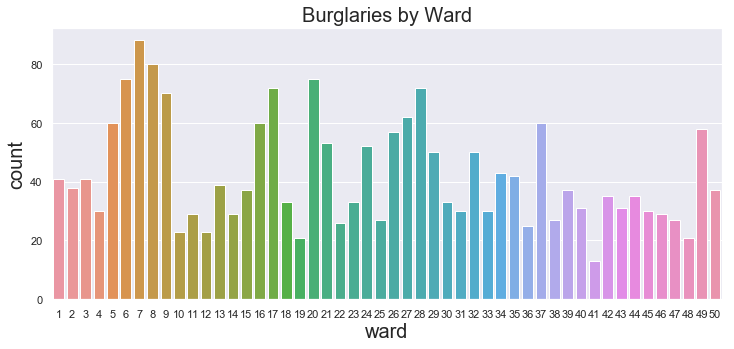

In [300]:
ax = sns.countplot(x="ward", data=burglary)
plt.title("Burglaries by Ward")
plt.show()

####  This is just a placeholder to associate these wards on the map, not the correct map yet. I am trying to make a similar map to show burglary statistics. 
![title](chicago_ward.jpg)

In [56]:
burglary_per_day = pd.DataFrame()
burglary_per_day =  burglary[['date', 'case_number']]
burglary_per_day = burglary_per_day.set_index(pd.to_datetime(burglary_per_day['date']))
burglary_per_day = burglary_per_day.resample('D').count()


Text(0.5, 0, 'Date')

Text(0, 0.5, 'Number of Cases Reported')

Text(0.5, 1.0, 'Burglaries Reported')

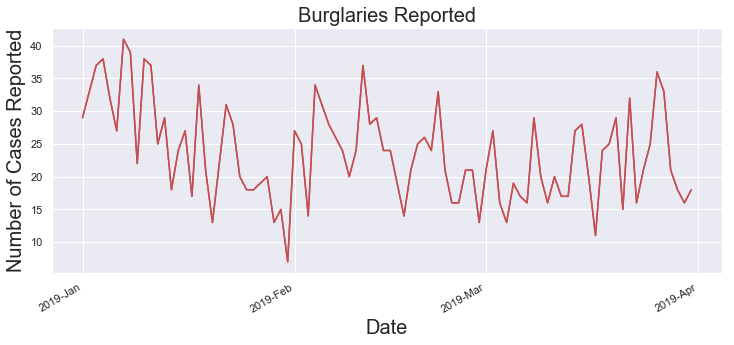

In [57]:
plt.rcParams['figure.figsize'] = 12,5
fig, ax = plt.subplots()
fig.autofmt_xdate()
#
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.DayLocator())
monthFmt = mdates.DateFormatter('%Y-%b')
ax.xaxis.set_major_formatter(monthFmt)

plt.plot(burglary_per_day.index, burglary_per_day, 'r-')
plt.xlabel('Date')
plt.ylabel('Number of Cases Reported')
plt.title('Burglaries Reported')
plt.show()

In [58]:
'''
import plotly.plotly as py
import plotly.figure_factory as ff
import numpy as np
import pandas as pd

aggs = ["count"]
agg = []
agg_func = []
for i in range(0, len(aggs)):
    agg = dict(
        args=['transforms[0].aggregations[0].func', aggs[i]],
        label=aggs[i],
        method='restyle'
    )
    agg_func.append(agg)


colorscale = [
    'rgb(193, 193, 193)',
    'rgb(239,239,239)',
    'rgb(195, 196, 222)',
    'rgb(144,148,194)',
    'rgb(101,104,168)',
    'rgb(65, 53, 132)'
]

fig = ff.create_choropleth(
    fips=fips, values=values, scope=['IL'],
    binning_endpoints=[14348, 63983, 134827, 426762, 2081313], colorscale=colorscale,
    county_outline={'color': 'rgb(255,255,255)', 'width': 0.5}, round_legend_values=True,
    legend_title='Crimes by Ward', title='Chicago IL'
)
py.iplot(fig, filename='choropleth_crimes_by_ward_chicago')
'''

'\nimport plotly.plotly as py\nimport plotly.figure_factory as ff\nimport numpy as np\nimport pandas as pd\n\naggs = ["count"]\nagg = []\nagg_func = []\nfor i in range(0, len(aggs)):\n    agg = dict(\n        args=[\'transforms[0].aggregations[0].func\', aggs[i]],\n        label=aggs[i],\n        method=\'restyle\'\n    )\n    agg_func.append(agg)\n\n\ncolorscale = [\n    \'rgb(193, 193, 193)\',\n    \'rgb(239,239,239)\',\n    \'rgb(195, 196, 222)\',\n    \'rgb(144,148,194)\',\n    \'rgb(101,104,168)\',\n    \'rgb(65, 53, 132)\'\n]\n\nfig = ff.create_choropleth(\n    fips=fips, values=values, scope=[\'IL\'],\n    binning_endpoints=[14348, 63983, 134827, 426762, 2081313], colorscale=colorscale,\n    county_outline={\'color\': \'rgb(255,255,255)\', \'width\': 0.5}, round_legend_values=True,\n    legend_title=\'Crimes by Ward\', title=\'Chicago IL\'\n)\npy.iplot(fig, filename=\'choropleth_crimes_by_ward_chicago\')\n'


## Business License
Data from business licenses. This will help us looking into licensing situation of the business whether there is tobaco/alcohol liscences or how that is related to the inspection failure. or may help answer if the businesses are more cleaner when they are close to duedate for license renewal?  

In [59]:
business = pd.read_csv('../data/raw/Business_Licenses.csv', parse_dates = True)

In [60]:
business.head()

,ID,LICENSE ID,ACCOUNT NUMBER,SITE NUMBER,LEGAL NAME,DOING BUSINESS AS NAME,ADDRESS,CITY,STATE,ZIP CODE,WARD,PRECINCT,WARD PRECINCT,POLICE DISTRICT,LICENSE CODE,...,APPLICATION TYPE,APPLICATION CREATED DATE,APPLICATION REQUIREMENTS COMPLETE,PAYMENT DATE,CONDITIONAL APPROVAL,LICENSE TERM START DATE,LICENSE TERM EXPIRATION DATE,LICENSE APPROVED FOR ISSUANCE,DATE ISSUED,LICENSE STATUS,LICENSE STATUS CHANGE DATE,SSA,LATITUDE,LONGITUDE,LOCATION
0,22308-20060816,1723393,29481,1,BELL OIL TERMINAL INC,Bell Oil Terminal LLC,3741 S PULASKI RD 1,CHICAGO,IL,60623,14.0,NaN,14-,8.0,1010,...,RENEW,NaN,06/21/2006,08/10/2006,N,08/16/2006,08/15/2007,08/10/2006,08/11/2006,AAI,NaN,NaN,41.825320,-87.723960,"(41.82531992987547, -87.72395999659746)"
1,1620668-20160516,2455262,295026,1,BUCCI BIG & TALL INC.,BUCCI BIG & TALL INC.,558 W ROOSEVELT RD,CHICAGO,IL,60607,25.0,28.0,25-28,1.0,1010,...,RENEW,NaN,03/15/2016,05/18/2016,N,05/16/2016,05/15/2018,05/18/2016,08/30/2016,AAI,NaN,NaN,41.867339,-87.641590,"(41.86733856638269, -87.64159005699716)"
2,2368602-20160616,2460909,291461,3,"PROJECT: VISION , INC.","PROJECT : VISION , INC",2301 S ARCHER AVE 1 1,CHICAGO,IL,60616,25.0,18.0,25-18,9.0,1625,...,RENEW,NaN,04/15/2016,06/21/2016,N,06/16/2016,06/15/2017,06/21/2016,06/22/2016,AAC,08/30/2016,NaN,41.850843,-87.638734,"(41.85084294374687, -87.63873424399071)"
3,2060891-20141016,2353257,357247,1,FOLASHADE'S CLEANING SERVICE INC.,FOLASHADE'S CLEANING SERVICE INC.,1965 BERNICE RD 1 1SW,LANSING,IL,60438,NaN,NaN,NaN,NaN,1010,...,RENEW,NaN,08/15/2014,04/01/2016,N,10/16/2014,10/15/2016,04/01/2016,04/01/2016,AAI,NaN,38.0,41.951316,-87.678586,"(41.95131555606832, -87.67858578019546)"
4,1144216-20070516,1804790,147,63,WALGREEN CO.,Walgreens # 05192,9148 S COMMERCIAL AVE 1ST,CHICAGO,IL,60617,10.0,25.0,10-25,4.0,1010,...,RENEW,NaN,03/23/2007,05/10/2007,N,05/16/2007,05/15/2008,05/10/2007,05/11/2007,AAI,NaN,5.0,41.728622,-87.551366,"(41.72862173556932, -87.55136646594693)"


In [61]:
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966713 entries, 0 to 966712
Data columns (total 34 columns):
ID                                   966713 non-null object
LICENSE ID                           966713 non-null int64
ACCOUNT NUMBER                       966713 non-null int64
SITE NUMBER                          966713 non-null int64
LEGAL NAME                           966709 non-null object
DOING BUSINESS AS NAME               966653 non-null object
ADDRESS                              966713 non-null object
CITY                                 966710 non-null object
STATE                                966701 non-null object
ZIP CODE                             966303 non-null object
WARD                                 895565 non-null float64
PRECINCT                             865973 non-null float64
WARD PRECINCT                        895738 non-null object
POLICE DISTRICT                      871348 non-null float64
LICENSE CODE                         966713 non-n

Whoa! There is alot of information in there! Now I am going to choose only a few columns which I think are more interesting.

In [66]:
columns_to_take = ['LICENSE ID', 'ID', 'LICENSE CODE', 'APPLICATION TYPE', 'LICENSE TERM EXPIRATION DATE', 'APPLICATION REQUIREMENTS COMPLETE','CONDITIONAL APPROVAL', 'BUSINESS ACTIVITY', 'DATE ISSUED', 'LICENSE STATUS CHANGE DATE' ]

In [67]:
columns_to_take

['LICENSE ID',
 'ID',
 'LICENSE CODE',
 'APPLICATION TYPE',
 'LICENSE TERM EXPIRATION DATE',
 'APPLICATION REQUIREMENTS COMPLETE',
 'CONDITIONAL APPROVAL',
 'BUSINESS ACTIVITY',
 'DATE ISSUED',
 'LICENSE STATUS CHANGE DATE']

In [68]:
business = business[columns_to_take]

In [69]:
business.head()

,LICENSE ID,ID,LICENSE CODE,APPLICATION TYPE,LICENSE TERM EXPIRATION DATE,APPLICATION REQUIREMENTS COMPLETE,CONDITIONAL APPROVAL,BUSINESS ACTIVITY,DATE ISSUED,LICENSE STATUS CHANGE DATE
0,1723393,22308-20060816,1010,RENEW,08/15/2007,06/21/2006,N,NaN,08/11/2006,NaN
1,2455262,1620668-20160516,1010,RENEW,05/15/2018,03/15/2016,N,Retail Sales of Clothing / Accessories / Shoes,08/30/2016,NaN
2,2460909,2368602-20160616,1625,RENEW,06/15/2017,04/15/2016,N,Not-For-Profit Selling Raffles for Prizes of $...,06/22/2016,08/30/2016
3,2353257,2060891-20141016,1010,RENEW,10/15/2016,08/15/2014,N,NaN,04/01/2016,NaN
4,1804790,1144216-20070516,1010,RENEW,05/15/2008,03/23/2007,N,NaN,05/11/2007,NaN


Now I want to merge the inspection and business data frames. we can do inner join on license number from inspection data and License ID from business data.

In [70]:
food_business = pd.merge(left=food_data,right=business, left_on='license', right_on='LICENSE ID')

In [71]:
food_business.head()

,address,aka_name,city,dba_name,facility_type,inspection_date,inspection_id,inspection_type,latitude,license,longitude,results,risk,minor_violations,non_critical_violations,critical_violations,facility_type_cat,risk_type_cat,LICENSE ID,ID,LICENSE CODE,APPLICATION TYPE,LICENSE TERM EXPIRATION DATE,APPLICATION REQUIREMENTS COMPLETE,CONDITIONAL APPROVAL,BUSINESS ACTIVITY,DATE ISSUED,LICENSE STATUS CHANGE DATE
0,1958 W CHICAGO AVE,SUBWAY,CHICAGO,SUBWAY,Restaurant,2019-01-22,2252942,Canvass,41.896023,1677083,-87.676995,1,Risk 1 (High),1,1,4,2,0,1677083,1677083-20060207,1006,ISSUE,11/15/2006,01/27/2006,N,Retail Sales of Perishable Foods,02/07/2006,NaN
1,4646 N MARINE DR,LOUIS A. WEISS MEMORIAL HOSPITAL,CHICAGO,LOUIS A. WEISS MEMORIAL HOSPITAL,Restaurant,2019-02-21,2268322,Canvass,41.966860,1249761,-87.649135,0,Risk 1 (High),0,1,9,2,0,1249761,1249761-20030925,1006,ISSUE,08/15/2004,08/01/2002,N,Retail Sales of Perishable Foods,09/25/2003,NaN
2,3141 W JACKSON BLVD,ALAIN LOCKE CHARTER ACADEMY,CHICAGO,ALAIN LOCKE CHARTER ACADEMY,School,2019-02-21,2268270,Canvass,41.877221,2206680,-87.705241,1,Risk 1 (High),0,0,2,3,0,2206680,2206680-20121229,4404,ISSUE,03/15/2013,NaN,N,Hotel - 7 or More Sleeping Rooms,12/29/2012,NaN
3,1852 W NORTH AVE,THE PASTA BOWL,CHICAGO,THE PASTA BOWL,Restaurant,2019-02-11,2261851,Canvass,41.910639,2374782,-87.674707,1,Risk 1 (High),3,0,8,2,0,2374782,2374782-20150409,1006,ISSUE,04/15/2017,01/14/2015,N,Preparation of Food and Dining on Premise With...,04/09/2015,NaN
4,2333 W GRAND AVE,"EL ORIGINAL CHAVAS TACOS, INC.",CHICAGO,"EL ORIGINAL CHAVAS TACOS, INC.",Restaurant,2019-02-05,2261489,Canvass,41.890569,1964229,-87.685574,0,Risk 1 (High),2,2,4,2,0,1964229,1964229-20090413,1006,ISSUE,09/15/2010,03/31/2009,N,Retail Sales of Perishable Foods,04/13/2009,NaN


In [72]:
food_business.shape

(1268, 28)

That's fewer rows than I would have inspected. I need to spend more time to understand what's going on here.

## Garbage and Sanitation From (311 complaints)
Is there trash/garbage/sanitation/rodents etc complaints in the neighborhood or how that affects the outcome of the inspection. 

In [74]:
service_data = pd.read_json('../data/raw/servicedata.json', convert_dates=['close_date', 'created_date', 'last_modified_date'])
service_data.head()

,city,closed_date,community_area,created_date,created_day_of_week,created_hour,created_month,duplicate,electrical_district,electricity_grid,last_modified_date,latitude,legacy_record,location,longitude,...,sanitation_division_days,sr_number,sr_short_code,sr_type,state,status,street_address,street_direction,street_name,street_number,street_type,ward,x_coordinate,y_coordinate,zip_code
0,None,None,16.0,2019-03-31 21:08:15,1,21,3,False,NaN,E012,2019-03-31 21:33:11,41.954382,False,"{'type': 'Point', 'coordinates': [-87.74081179...",-87.740812,...,None,SR19-01250236,CHECKFOR,Sewer Cleaning Inspection Request,None,Open,4026 N Kilbourn AVE,N,Kilbourn,4026,AVE,45.0,1.145422e+06,1.926521e+06,None
1,None,2019-03-26T06:48:04.000,22.0,2019-03-01 07:28:15,6,7,3,False,5.0,J017,2019-03-26 06:48:04,41.917701,False,"{'type': 'Point', 'coordinates': [-87.68925839...",-87.689258,...,Thursday,SR19-01091746,SCB,Sanitation Code Violation,None,Completed,2000 N MILWAUKEE AVE,N,MILWAUKEE,2000,AVE,1.0,1.159545e+06,1.913256e+06,60647
10,None,2019-03-26T03:04:27.000,76.0,2019-03-11 16:05:25,2,16,3,False,1.0,U109,2019-03-26 03:04:27,41.974186,False,"{'type': 'Point', 'coordinates': [-87.84235414...",-87.842354,...,Monday,SR19-01140158,CHECKFOR,Sewer Cleaning Inspection Request,None,Completed,5211 N POTAWATOMIE AVE,N,POTAWATOMIE,5211,AVE,41.0,1.117760e+06,1.933563e+06,60656
100,None,2019-01-03T12:03:58.000,67.0,2019-01-01 11:27:33,3,11,1,True,11.0,L036,2019-01-16 17:24:53,41.785938,False,"{'type': 'Point', 'coordinates': [-87.673112, ...",-87.673112,...,Friday,SR19-00001224,SGA,Rodent Baiting/Rat Complaint,None,Completed,5922 S WINCHESTER AVE,S,WINCHESTER,5922,AVE,16.0,1.164307e+06,1.865278e+06,60636
1000,None,2019-03-28T08:33:55.000,70.0,2019-03-26 11:12:16,3,11,3,False,NaN,E040,2019-03-28 08:33:55,41.750832,False,"{'type': 'Point', 'coordinates': [-87.73567324...",-87.735673,...,None,SR19-01222821,SIE,Garbage Cart Maintenance,None,Completed,7804 S KOLMAR AVE,S,KOLMAR,7804,AVE,18.0,1.147336e+06,1.852358e+06,60652


In [75]:
shape = service_data.shape
print(" So there are %d rows and %d columns in the data" % (shape[0], shape[1]))


 So there are 21851 rows and 36 columns in the data


service_data.info()

I now want to count number of these incidents around the business and within some prespecified time. We can optimize the distance and the time windows but for the first pass study I am just foucsing on within 5 miles radii and the 7 days before the inspection date. 

In [78]:
# This is the function to calculate between two locations using (lat, long) info. 
# This is famout Haversine formula from geoscience. 
def get_distance(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.deg2rad, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 3956 # Radius of earth in miles 
    return c * r

In [79]:
def count_burglaries(longitude, latitude, date, df):
    matching_hits = 0
    df['restaurant_long'] = longitude
    df['restaurant_lat'] = latitude
    df['hit_date'] = date
    df['distance'] = get_distance(df['restaurant_long'], df['restaurant_lat'], df['longitude'], df['latitude'])
    df['end_of_time_window'] =  df['hit_date'] - df['date']
    dfNew = df[(df['distance'] < 0.5) & (df['end_of_time_window'] < pd.Timedelta(8,'D'))]

    return dfNew.shape[0]

In [80]:
def count_sanitation_complaints(longitude, latitude, date, df):
    matching_hits = 0
    df['restaurant_long'] = longitude
    df['restaurant_lat'] = latitude
    df['hit_date'] = date
    df['distance'] = get_distance(df['restaurant_long'], df['restaurant_lat'], df['longitude'], df['latitude'])
    df['end_of_time_window'] =  df['hit_date'] - df['created_date']
    dfNew = df[(df['distance'] < 0.5) & (df['end_of_time_window'] < pd.Timedelta(8,'D')) & (df['duplicate'] !=1)]

    return dfNew.shape[0]

In [81]:
%timeit food_data['burglaries_this_week'] = food_data.apply(lambda x: count_burglaries(x['longitude'], x['latitude'], x['inspection_date'], burglary), axis=1)

7 s ± 137 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [82]:
%timeit food_data['service_complains_this_week'] = food_data.apply(lambda x: count_sanitation_complaints(x['longitude'], x['latitude'], x['inspection_date'], service_data), axis=1)

14.9 s ± 372 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [83]:
#food_data['yelp_id'] = food_data.apply(lambda x: get_business_match(x['aka_name'], x['address']), axis=1)

In [84]:
#food_data['yelp_rating'] = food_data.apply(lambda x: get_rating(x["yelp_id"]), axis=1)

In [85]:
food_data.head()

,address,aka_name,city,dba_name,facility_type,inspection_date,inspection_id,inspection_type,latitude,license,longitude,results,risk,minor_violations,non_critical_violations,critical_violations,facility_type_cat,risk_type_cat,burglaries_this_week,service_complains_this_week
0,1958 W CHICAGO AVE,SUBWAY,CHICAGO,SUBWAY,Restaurant,2019-01-22,2252942,Canvass,41.896023,1677083,-87.676995,1,Risk 1 (High),1,1,4,2,0,12,173
1003,606 S STATE ST,Jones Academy High School,CHICAGO,Jones Academy High School,School,2019-01-10,2252303,Canvass,41.874419,2132,-87.627755,1,Risk 1 (High),2,0,1,3,0,5,24
1004,4646 N MARINE DR,LOUIS A. WEISS MEMORIAL HOSPITAL,CHICAGO,LOUIS A. WEISS MEMORIAL HOSPITAL,Restaurant,2019-02-21,2268322,Canvass,41.966860,1249761,-87.649135,0,Risk 1 (High),0,1,9,2,0,2,23
1005,3141 W JACKSON BLVD,ALAIN LOCKE CHARTER ACADEMY,CHICAGO,ALAIN LOCKE CHARTER ACADEMY,School,2019-02-21,2268270,Canvass,41.877221,2206680,-87.705241,1,Risk 1 (High),0,0,2,3,0,6,148
1006,1852 W NORTH AVE,THE PASTA BOWL,CHICAGO,THE PASTA BOWL,Restaurant,2019-02-11,2261851,Canvass,41.910639,2374782,-87.674707,1,Risk 1 (High),3,0,8,2,0,8,104


In [86]:
#food_data['yelp_rating'].hist()

In [87]:
#features = []

#food_data.to_csv('processed_food_inspect_data.csv')
#food_data.to_json('processed_food_inspect_data.json')

Now that we have some features we can start building some baseline models:

In [90]:
features = ['risk_type_cat', 'minor_violations', 'non_critical_violations', 'facility_type_cat', 'burglaries_this_week', 'service_complains_this_week']

In [91]:
X = food_data[features]
Y = food_data['results']

In [92]:
X.shape

(1953, 6)

Y.shape

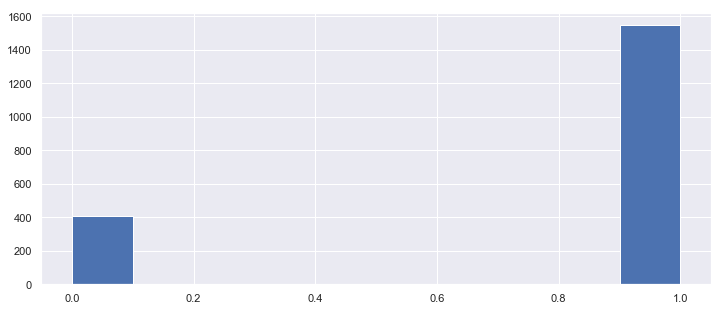

In [95]:
Y.hist()

We should note that there is class imbalance here and we should be careful about building our classfier. 

In [98]:
#Make sure that there are no n/a values in our data frame. 
print(X.isna().sum())
print(Y.isna().sum())

risk_type_cat                  0
minor_violations               0
non_critical_violations        0
facility_type_cat              0
burglaries_this_week           0
service_complains_this_week    0
dtype: int64
0


### Baseline Models 

In [141]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=0)

In [161]:
# Create dummy classifer
dummy = DummyClassifier(strategy='stratified', random_state=0) 
# stratified strategy generates random predictions by respecting the training set class distribution.

# "Train" model
dummy.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=0, strategy='stratified')

In [162]:
# Get accuracy score
dummy.score(X_test, y_test)  

0.6775193798449612

In [163]:
# train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression
# instantiate model
logreg = LogisticRegression(random_state=0, class_weight='balanced')

# fit model
logreg.fit(X_train, y_train)

# make class predictions for the testing set
y_pred_class = logreg.predict(X_test)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=0,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

0.6


In [165]:
# calculate accuracy
print(metrics.accuracy_score(y_test, y_pred_class))
print(metrics.confusion_matrix(y_test, y_pred_class))

0.6
[[ 70  69]
 [189 317]]


In [166]:
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
print(metrics.roc_auc_score(y_test, y_pred_prob))

0.644204794267353


<Figure size 576x576 with 0 Axes>

(0.0, 1.0)

(0.0, 1.0)

Text(0.5, 1.0, 'ROC curve for Food Inspection Classifier')

Text(0.5, 0, 'False Positive Rate (1 - Specificity)')

Text(0, 0.5, 'True Positive Rate (Sensitivity)')

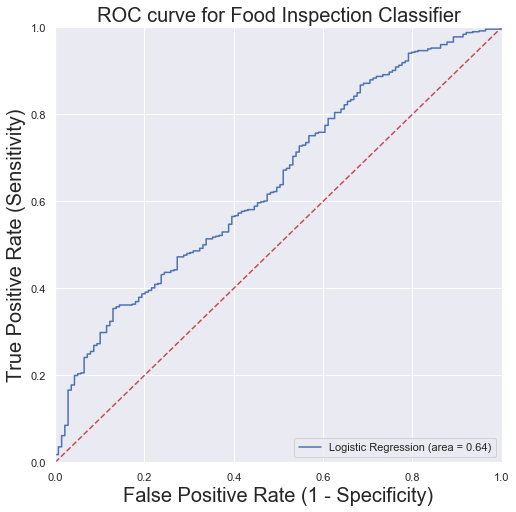

In [167]:
plt.figure(figsize=(8,8))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % metrics.roc_auc_score(y_test, y_pred_prob))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Food Inspection Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()